Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.
Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 
Постройте модель с предельно большим значением F1-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте F1-меру на тестовой выборке самостоятельно.
Дополнительно измеряйте AUC-ROC, сравнивайте её значение с F1-мерой.

Описание данных
Данные находятся в файле /datasets/Churn.csv (англ. «отток клиентов»). Скачать датасет
Признаки
RowNumber — индекс строки в данных
CustomerId — уникальный идентификатор клиента
Surname — фамилия
CreditScore — кредитный рейтинг
Geography — страна проживания
Gender — пол
Age — возраст
Tenure — сколько лет человек является клиентом банка
Balance — баланс на счёте
NumOfProducts — количество продуктов банка, используемых клиентом
HasCrCard — наличие кредитной карты
IsActiveMember — активность клиента
EstimatedSalary — предполагаемая зарплата
Целевой признак
Exited — факт ухода клиента

Загрузите и подготовьте данные. Поясните порядок действий.
Исследуйте баланс классов, обучите модель без учёта дисбаланса. Кратко опишите выводы.
Улучшите качество модели, учитывая дисбаланс классов. Обучите разные модели и найдите лучшую. Кратко опишите выводы.
Проведите финальное тестирование.

[Делим данные на выборки](#split)

[One-Hot Encoding для категориальных данных](#OHE)

[Дерево решений на не сбалансированных данных](#pred_tree)

[Случайный лес на не сбалансированных данных](#RandomForest)

[Модель логистической регрессии на не сбалансированных данных](#LogRegres)

In [333]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn import tree
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder,StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, roc_curve,\
                            confusion_matrix, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [334]:
try:
    df = pd.read_csv('/datasets/Churn_2.csv')
except:
    df = pd.read_csv('Churn_2.csv') 

In [335]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [336]:
df.shape

(10000, 14)

In [337]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


**Названия столбцов:**
 - RowNumber — индекс строки в данных
 - CustomerId — уникальный идентификатор клиента
 - Surname — фамилия
 - CreditScore — кредитный рейтинг
 - Geography — страна проживания
 - Gender — пол
 - Age — возраст
 - Tenure — сколько лет человек является клиентом банка
 - Balance — баланс на счёте
 - NumOfProducts — количество продуктов банка, используемых клиентом
 - HasCrCard — наличие кредитной карты
 - IsActiveMember — активность клиента
 - EstimatedSalary — предполагаемая зарплата
 - Exited — факт ухода клиента

In [338]:
#Теперь посмотрим на пропуски,используя  градиент:
pd.DataFrame(round(df.isna().mean()*100,1)).style.background_gradient('coolwarm')

,0
RowNumber,0.000000
CustomerId,0.000000
Surname,0.000000
CreditScore,0.000000
Geography,0.000000
Gender,0.000000
Age,0.000000
Tenure,0.000000
Balance,0.000000
NumOfProducts,0.000000


In [339]:
#correctness of column names
df.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

In [340]:
print(f'Count duplicated: {df.duplicated().sum()}')

Count duplicated: 0


### Исследование задачи

In [341]:
#Удалим из дальнейшей работы столбцы с индексом строки, id клиента и фамилиями,
#для построения моделей машинного обучения они нам не потребуются 
df = df.drop(['RowNumber', 'CustomerId', 'Surname'] , axis=1)

In [342]:
df.Geography.nunique()

3

<AxesSubplot:>

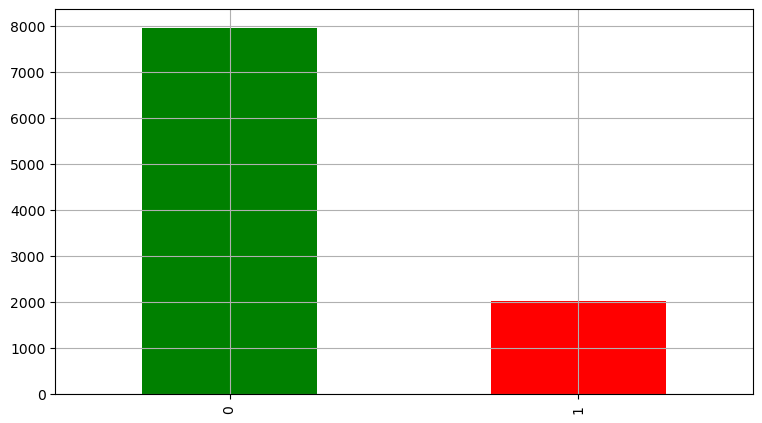

In [343]:
# Exited — факт ухода клиента,посмотрим графически на распределение данных в колонке
df.Exited.value_counts().plot(kind='bar',figsize=(9,5),color=['g','r'],grid=True)

<AxesSubplot:>

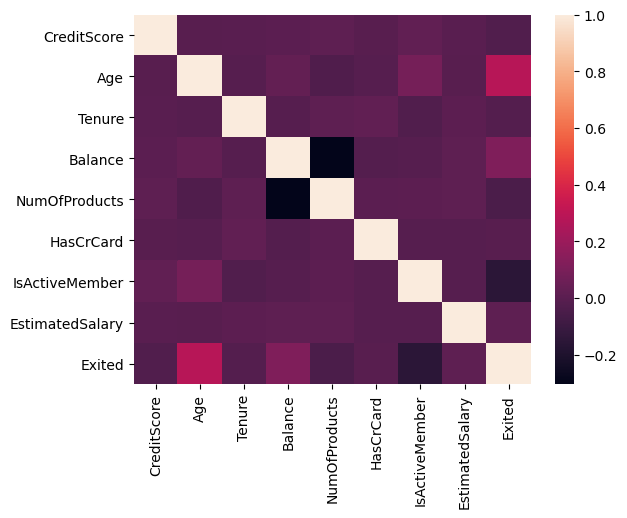

In [344]:
#корреляция целевого показателя в разрезе признаков
sns.heatmap(df.corr())


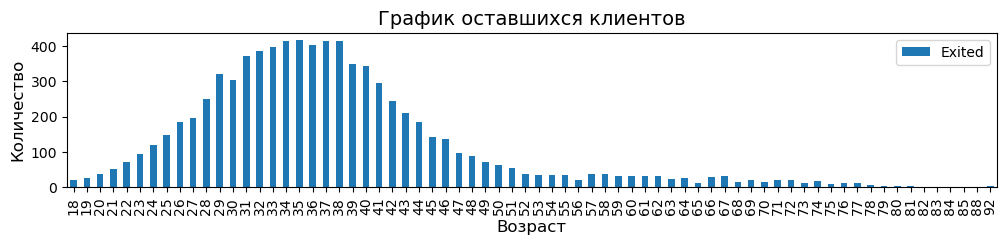

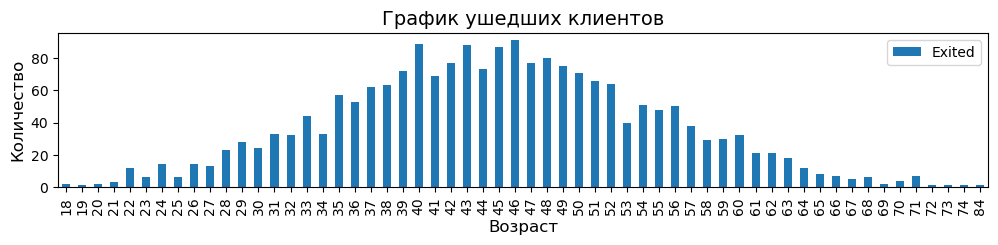

In [345]:
df.query('Exited==0').groupby('Age')['Exited'].count().plot(kind='bar',legend=True,figsize=(12,2))
plt.title('График оставшихся клиентов',fontsize=14)
plt.xlabel('Возраст', fontsize = 12)
plt.ylabel('Количество',fontsize = 12)
plt.show()
df.query('Exited==1').groupby('Age')['Exited'].count().plot(kind='bar',legend=True,figsize=(12,2))
plt.title('График ушедших клиентов',fontsize=14)
plt.xlabel('Возраст', fontsize = 12)
plt.ylabel('Количество',fontsize = 12)
plt.show()

In [346]:
print('Средний возраст оставшихся клиентов:', round(df.query('Exited == 0')['Age'].mean()))
print('Средний возраст ушедших клиентов:',round(df.query('Exited == 1')['Age'].mean()))

Средний возраст оставшихся клиентов: 37.0
Средний возраст ушедших клиентов: 45.0


### делим данные на выборки
<a id='split'></a>

In [347]:
# данные разбивают на три части: обучающую, валидационную и тестовую, в соотношении 3:1:1
# делим обучающую от тестовой  
df_train, df_test = train_test_split(df,test_size=0.4,random_state=42,stratify=df['Exited'])
X = df_test.drop(['Exited'],axis=1)
y = df_test.Exited

In [348]:
print(X.shape,'\n',y.shape)

(4000, 10) 
 (4000,)


In [349]:
#разобьём выборку на валидационную и тестовую, пополам
X_valid, X_test, y_valid, y_test = \
train_test_split(X, y, test_size = 0.5, random_state = 12345, stratify = y)

In [350]:
print(X_valid.shape, X_test.shape, y_valid.shape, y_test.shape)

(2000, 10) (2000, 10) (2000,) (2000,)


In [351]:
print(f' Кол-во строк y_valid {np.bincount(y_valid)}','\n',f'Кол-во строк y_test  {np.bincount(y_test)}')

 Кол-во строк y_valid [1592  408] 
 Кол-во строк y_test  [1593  407]


In [352]:
X_train = df_train.drop(['Exited'], axis = 1)
y_train = df_train.Exited

Проверим правильность деления выборок:

In [353]:
print('Размер обучающей выборки:', X_train.shape)
print('Размер валидационной выборки:', X_valid.shape)
print('Размер тестовой выборки:', X_test.shape)

Размер обучающей выборки: (6000, 10)
Размер валидационной выборки: (2000, 10)
Размер тестовой выборки: (2000, 10)


##### Переходим к кодированию категориальных признаков

<a id='OHE'></a>

Cмотрим на уникальные значения столбцов, которые будем кодировать с помощью библиотеки sklearn.preprocessing.OneHotEncoder

In [354]:
print(X_train.Geography.unique())
print(X_train.Gender.unique())

['Germany' 'France' 'Spain']
['Female' 'Male']


In [355]:
#Создадим новый список с именами колонок с категориальными признаками:
category = ['Geography', 'Gender']

In [356]:
#Приступаем к кодированию:
ohe = OneHotEncoder()

In [357]:
ohe_values_train = ohe.fit_transform(X_train[category].values)
print(ohe.categories_)

[array(['France', 'Germany', 'Spain'], dtype=object), array(['Female', 'Male'], dtype=object)]


In [358]:
ohe_values_train.toarray()

array([[0., 1., 0., 1., 0.],
       [1., 0., 0., 1., 0.],
       [0., 1., 0., 0., 1.],
       ...,
       [1., 0., 0., 1., 0.],
       [0., 0., 1., 0., 1.],
       [0., 0., 1., 0., 1.]])

In [359]:
ohe_train = pd.DataFrame(ohe_values_train.toarray())

In [360]:
#Уберём индексы строк, чтобы правильно склеить строки:
X_train.reset_index(drop= True , inplace= True )
X_train.head(5)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,527,Germany,Female,39,9,96748.89,2,1,0,94711.43
1,677,France,Female,27,2,0.00,2,0,1,114685.92
2,628,Germany,Male,40,5,181768.32,2,1,1,129107.97
3,470,Spain,Female,48,6,140576.11,1,1,1,116971.05
4,768,Germany,Female,43,2,129264.05,2,0,0,19150.14


In [361]:
ohe_train.rename(columns = {0: 'France', 1: 'Germany', 2: 'Spain', 3: 'Female', 4: 'Male'}, inplace = True)

In [362]:
X_train = pd.concat([X_train, ohe_train], axis=1).drop(['Geography', 'Gender'], axis=1)

In [363]:
X_train.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,France,Germany,Spain,Female,Male
0,527,39,9,96748.89,2,1,0,94711.43,0.0,1.0,0.0,1.0,0.0
1,677,27,2,0.00,2,0,1,114685.92,1.0,0.0,0.0,1.0,0.0
2,628,40,5,181768.32,2,1,1,129107.97,0.0,1.0,0.0,0.0,1.0
3,470,48,6,140576.11,1,1,1,116971.05,0.0,0.0,1.0,1.0,0.0
4,768,43,2,129264.05,2,0,0,19150.14,0.0,1.0,0.0,1.0,0.0


In [364]:
#перекодируем категориальные признаки в валидационной и тестовой выборках:
ohe_values_valid = ohe.transform(X_valid[category].values)
ohe_valid = pd.DataFrame(ohe_values_valid.toarray())
X_valid.reset_index(drop= True , inplace= True )
ohe_valid.rename(columns = {0: 'France', 1: 'Germany', 2: 'Spain', 3: 'Female', 4: 'Male'}, inplace = True)
X_valid = pd.concat([X_valid, ohe_valid], axis=1).drop(['Geography', 'Gender'], axis=1)
X_valid.head(5)


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,France,Germany,Spain,Female,Male
0,652,36,1,0.00,2,1,1,151314.98,1.0,0.0,0.0,0.0,1.0
1,752,42,3,65046.08,2,0,1,140139.28,0.0,1.0,0.0,1.0,0.0
2,850,34,2,0.00,2,0,0,51919.04,1.0,0.0,0.0,1.0,0.0
3,683,29,9,0.00,2,1,1,48849.89,1.0,0.0,0.0,1.0,0.0
4,526,36,1,0.00,1,1,0,160696.72,1.0,0.0,0.0,0.0,1.0


In [365]:
#Сохраним все целочисленные признаки в список numeric.
#Масштабируем(стандартизируем) признаки
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
scaler = StandardScaler()
X_train[numeric] = scaler.fit_transform(X_train[numeric])
X_train.head(3)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,France,Germany,Spain,Female,Male
0,-1.283897,0.008566,1.378433,0.330105,0.783996,1,0,-0.084061,0.0,1.0,0.0,1.0,0.0
1,0.271537,-1.139895,-1.044424,-1.220584,0.783996,0,1,0.264021,1.0,0.0,0.0,1.0,0.0
2,-0.236571,0.104271,-0.006057,1.692794,0.783996,1,1,0.515344,0.0,1.0,0.0,0.0,1.0


In [366]:
X_valid[numeric] = scaler.transform(X_valid[numeric])
X_valid.head(3)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,France,Germany,Spain,Female,Male
0,0.012298,-0.278549,-1.390547,-1.220584,0.783996,1,1,0.902331,1.0,0.0,0.0,0.0,1.0
1,1.049254,0.295681,-0.698302,-0.178027,0.783996,0,1,0.707579,0.0,1.0,0.0,1.0,0.0
2,2.065472,-0.469960,-1.044424,-1.220584,0.783996,0,0,-0.829776,1.0,0.0,0.0,1.0,0.0


In [367]:
X_test[numeric] = scaler.transform(X_test[numeric])
X_test.head(3)

C:\Users\radim\anaconda3\envs\ML_STEPIC\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\radim\anaconda3\envs\ML_STEPIC\lib\site-packages\pandas\core\indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
1154,-1.169832,Spain,Male,0.008566,-1.044424,0.747227,0.783996,1,1,-0.715667
6266,-1.180201,Spain,Female,-0.565665,0.686188,0.960535,-0.919109,1,0,-0.641092
9482,0.582624,France,Male,0.104271,-1.390547,-1.220584,0.783996,1,0,-1.488990


### Дерево решений на не сбалансированных данных
<a id='pred_tree'></a>

In [368]:
y_train

6851    0
7026    0
5705    0
9058    0
9415    0
       ..
1467    0
4644    0
8942    0
2935    0
6206    0
Name: Exited, Length: 6000, dtype: int64

In [371]:
best_model_tree = None
best_recall_score = 0
best_depth_tree = 0
best_predictions_tree = 0

best_precision_score = 0
best_f1_score_tree = 0
metric_f1_list = []
depth_list = []
for depth in range(1, 20):
    model_tree = DecisionTreeClassifier(random_state=42, max_depth=depth)
    model_tree.fit(X_train, y_train)
    predictions_tree = model_tree.predict(X_valid)
    f1_score_tree = f1_score(y_valid, predictions_tree)
    metric_f1_list.append(f1_score_tree)
    depth_list.append(depth)
    if f1_score_tree > best_f1_score_tree:
        best_model_tree = model_tree
        best_predictions_tree = predictions_tree
        best_f1_score_tree =f1_score_tree
        best_depth_tree = depth

In [373]:
print('Количество деревьев:', best_depth_tree)
print("Лучшая F1-мера", best_f1_score_tree)
print("Полнота" , recall_score(y_valid, best_predictions_tree))
print("Точность", precision_score(y_valid, best_predictions_tree))

Количество деревьев: 5
Лучшая F1-мера 0.5929078014184397
Полнота 0.5122549019607843
Точность 0.7037037037037037


#### построим график расчётов лучшей метрики F1 - меры

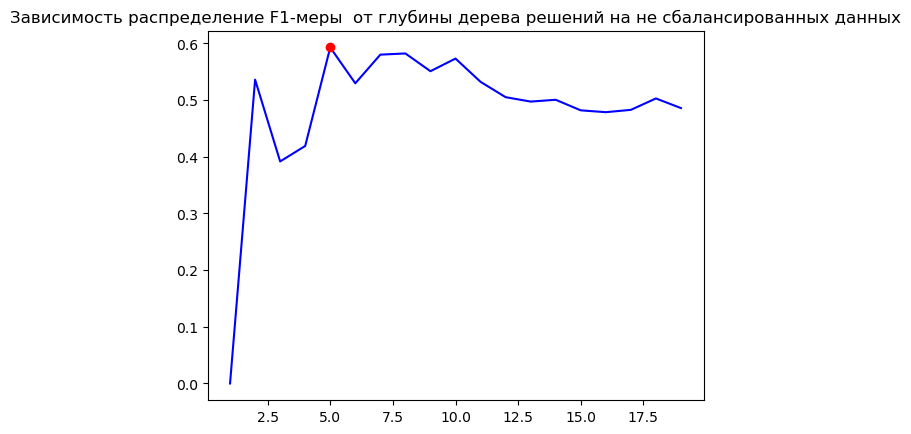

In [378]:
plt.plot(depth_list,metric_f1_list,color='b')
plt.plot(best_depth_tree, best_f1_score_tree,  ls="", marker="o", label="points", color = 'r')
plt.title('Зависимость распределение F1-меры  от глубины дерева решений на не сбалансированных данных')
plt.show()

###  Случайный лес на не сбалансированных данных
<a id='RandomForest'></a>

In [388]:
#Глубину берём от 1-20, а количество деревьев - от 10-51 с шагом 10.
%time

best_model_forest = None
best_est_forest = 0
best_predictions_forest = 0
best_f1_score_forest = 0
best_depth = 0
for depth in range (1,20,1):
    for est in range(10,51,10):
        model_forest = RandomForestClassifier(random_state=42,n_estimators=est,max_depth=depth)
        model_forest.fit(X_train,y_train)
        predictions_forest = model_forest.predict(X_valid)
        f1_score_forest = f1_score(y_valid,predictions_forest)
        if f1_score_forest>best_f1_score_forest:
            best_f1_score_forest = f1_score_forest
            best_model_forest = model_forest
            best_est_forest = est
            best_depth = depth
            best_predictions_forest = predictions_forest
            
            



Wall time: 0 ns


In [390]:
print('Количество деревьев:', best_est_forest)
print('Наилучшая глубина:', best_depth)
print("Лучшая F1-мера", best_f1_score_forest)
print("Полнота" , recall_score(y_valid, best_predictions_forest))
print("Точность", precision_score(y_valid, best_predictions_forest))

Количество деревьев: 40
Наилучшая глубина: 15
Лучшая F1-мера 0.5937961595273265
Полнота 0.49264705882352944
Точность 0.7472118959107806


### Вывод:

#### Модель случайного леса:

Количество деревьев: 40

Наилучшая глубина: 15

Лучшая F1-мера 0.5937961595273265

Полнота 0.49264705882352944

Точность 0.7472118959107806

### Модель логистической регрессии на не сбалансированных данных
<a id='LogRegres'></a>

In [391]:
model_logistic = LogisticRegression(random_state=42, solver='liblinear')
model_logistic.fit(X_train, y_train) 
predictions_logistic = model_logistic.predict(X_valid)
f1_logistic= f1_score(y_valid, predictions_logistic)

In [392]:
print("Лучшая F1-мера", f1_logistic)
print("Полнота" , recall_score(y_valid, predictions_logistic))
print("Точность", precision_score(y_valid, predictions_logistic))

Лучшая F1-мера 0.3217550274223035
Полнота 0.21568627450980393
Точность 0.6330935251798561


### Вывод:

#### Модель логистической регрессии:

Лучшая F1-мера 0.3217550274223035

Полнота 0.21568627450980393

Точность 0.6330935251798561